In [1]:
import numpy as np
from datetime import datetime, timedelta
import glob
import mne
import re
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') #living on the edge (but i really hate warnings)

In [2]:
#Gather all resting state recordings
#this takes a while due to some 10khz recordings
BASE_PATH = '/mnt/sinuhe/data_raw/**/**/**/*.fif'

files = glob.glob(BASE_PATH)
files = [file for file in files if 'rest' in file or 'Rest' in file or 'REST' in file]

subject_ids = []
measurement_age = []
measurement_date = []
measurement_age_days = []
clean_path = []
fs_1k = []

for file in files:
    f_split = file.split('/')
    cur_id = f_split[-1].lower()[:12]
        
    if re.match("\d{8}[a-z]{4}", cur_id) and 'sss' not in f_split[-1]: #only take proper ids for now

        cur_data = mne.io.read_raw_fif(file, verbose=False, allow_maxshield=True)
        if cur_data.info['sfreq'] == 1000: #only take 1kHz recordings for now
            fs_1k.append(True)
        else:
            fs_1k.append(False)
        subject_ids.append(cur_id)
        recording_date = datetime.strptime(f_split[-2], '%y%m%d')
        try:
            birth_date = datetime.strptime(f_split[-1][:8], '%Y%m%d') #in ~2 cases dates are formatted weird
        except ValueError:
            pass
        
        measurement_age.append((recording_date - birth_date) // timedelta(days=365.2425))
        measurement_age_days.append((recording_date - birth_date).days)
        measurement_date.append(recording_date)
        clean_path.append(file)
        
        
df = pd.DataFrame({'subject_id': np.array(subject_ids),
                   'measurement_age': np.array(measurement_age),
                   'measurement_age_days': np.array(measurement_age_days),
                   'measurement_date': np.array(measurement_date),
                   'path': np.array(clean_path),
                   'fs_1k': np.array(fs_1k)})

df = df[df['measurement_age'] < 100] #remove methusalem
df

,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k
1,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
2,19851130eifi,31,11436,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
4,19950604llzm,21,7964,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
5,19961118brsh,20,7431,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
...,...,...,...,...,...,...
2141,19590805crul,63,23129,2022-12-01,/mnt/sinuhe/data_raw/ch_sbg_hearing/subject_su...,True
2142,19591124eakb,63,23023,2022-12-06,/mnt/sinuhe/data_raw/ch_sbg_hearing/subject_su...,True
2143,19610527jtce,61,22480,2022-12-13,/mnt/sinuhe/data_raw/ch_sbg_hearing/subject_su...,True
2144,19550905atta,67,24573,2022-12-15,/mnt/sinuhe/data_raw/ch_sbg_hearing/subject_su...,True


In [5]:
df.to_csv('./resting_list.csv')

In [6]:
df_unique = df.drop_duplicates(subset='subject_id', keep='last')
df_unique.to_csv('./resting_list_single.csv')

(array([905., 703., 165.,  89.,  38.,  96., 114.,  27.,   7.,   1.]),
 array([18. , 24.8, 31.6, 38.4, 45.2, 52. , 58.8, 65.6, 72.4, 79.2, 86. ]),
 <BarContainer object of 10 artists>)

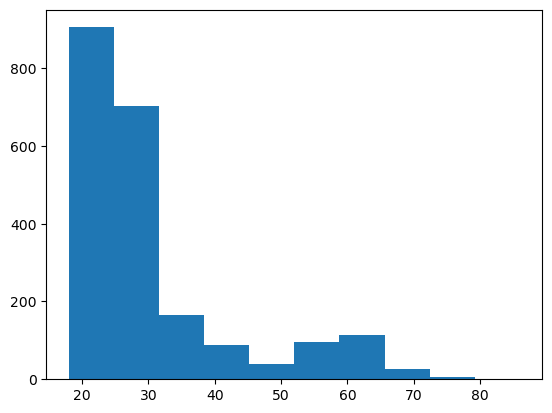

In [7]:
plt.hist(df['measurement_age'])

In [8]:
#Get subject ids with multiple recordings
df_1k = df[df['fs_1k']]
ids, counts = np.unique(df_1k['subject_id'], return_counts=True)
id_list = ids[counts > 4]

df_multi = df_1k.query('subject_id in @id_list')
df_multi.reset_index(inplace=True)
df_multi.drop(columns='index', inplace=True)
df_multi.to_csv('./resting_list_multi.csv')

df_multi

,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k
0,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
1,19810726gdzn,35,13141,2017-07-18,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
2,19870319wlgl,31,11390,2018-05-25,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
3,19800616mrgu,38,13987,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
4,19940430slbc,24,8921,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
...,...,...,...,...,...,...
556,19910612crke,31,11457,2022-10-24,/mnt/sinuhe/data_raw/sg_cocktail_eye/subject_s...,True
557,19800908igdb,42,15397,2022-11-04,/mnt/sinuhe/data_raw/sg_cocktail_eye/subject_s...,True
558,19891222gbhl,32,12036,2022-12-05,/mnt/sinuhe/data_raw/sg_cocktail_eye/subject_s...,True
559,19970203urmr,25,9437,2022-12-06,/mnt/sinuhe/data_raw/sg_cocktail_eye/subject_s...,True


In [9]:
rep_ids = ids[counts > 4]
reps = counts[counts > 4]

In [14]:
reps#

array([10, 11, 10,  5, 31,  6,  6, 16,  5,  6, 10, 16, 10, 18, 30,  6,  8,
       10, 10, 13, 13,  5, 14,  9,  6,  5, 11, 11, 15, 10,  6,  6, 11, 10,
       11,  9, 24, 10,  5,  5, 10, 14, 12, 26, 10, 10,  5, 11, 10, 10, 10])

In [15]:
age_dist = []

for subject in rep_ids:
    cur_df = df_multi.query(f'subject_id == "{subject}"')
    age_dist.append(cur_df['measurement_age'].max() - cur_df['measurement_age'].min())

rep_ids[np.array(age_dist) > 0]

array(['19680529eidx', '19791024eetm', '19800616mrgu', '19800908igdb',
       '19810726gdzn', '19860620hrwc', '19870319wlgl', '19880705lhko',
       '19891222gbhl', '19910612crke', '19910703eigl', '19910704hbea',
       '19910811sbsu', '19910823ssld', '19920208dnkp', '19921204rtse',
       '19930118imsh', '19930506urhe', '19930630mnsu', '19930819crbo',
       '19940430slbc', '19940930nkbh', '19950913gbwl', '19951227eipo',
       '19960122urfo', '19960411mnfl', '19960418gbsh', '19960630cahi',
       '19961106sbgi', '19961112cahn', '19970203urmr', '19971028mrhs',
       '19990303hlas'], dtype=object)

(array([18.,  7.,  0.,  6.,  0.,  5.,  6.,  0.,  8.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

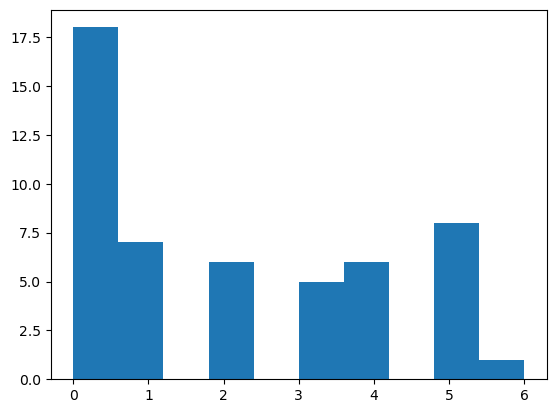

In [16]:
plt.hist(age_dist)

In [17]:
rep_ids[np.array(age_dist) > 0].shape

(33,)

<BarContainer object of 51 artists>

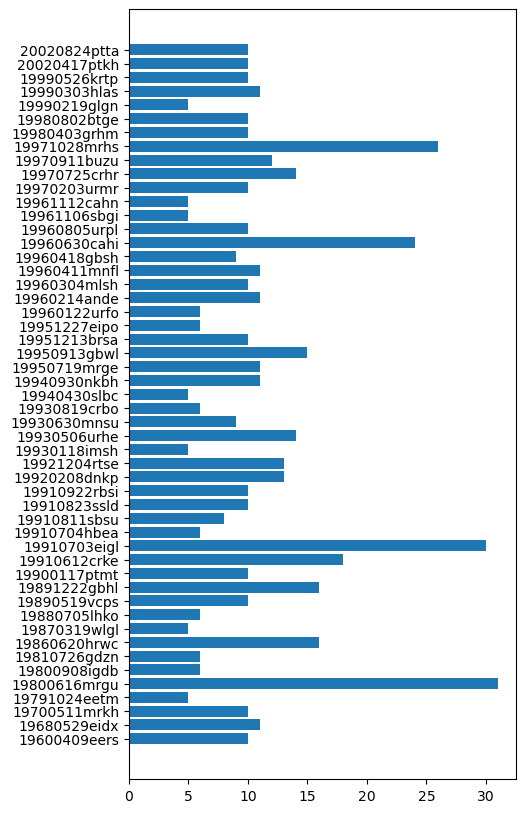

In [18]:
plt.figure(figsize=(5,10))
plt.barh(y=rep_ids, width=reps)